In [20]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os
import json
import pickle as pickle

import trackintel as ti
from trackintel.io.dataset_reader import read_geolife, geolife_add_modes_to_triplegs
from trackintel.analysis.tracking_quality import temporal_tracking_quality, _split_overlaps


In [21]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
print(ti.__version__)

1.2.3


# Load data

In [3]:
DATA_DIR = os.path.join("..", "..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", "..", CONFIG["data_dir"])

In [4]:
## read
pfs, mode_labels = read_geolife(os.path.join("..", "..", CONFIG["data_dir"], "Data"), print_progress=True)

100%|██████████| 182/182 [03:15<00:00,  1.07s/it]


In [5]:
# mode_labels is a dictionary of pandas dataframes, with keys corresponding to the user id
mode_labels.keys()

dict_keys([10, 20, 21, 52, 53, 56, 58, 59, 60, 62, 64, 65, 67, 68, 69, 73, 75, 76, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 124, 125, 126, 128, 129, 136, 138, 139, 141, 144, 147, 153, 154, 161, 163, 167, 170, 174, 175, 179])

# Identify users with high tracking quality (for tutorial)

In [6]:
# generate staypoints
pfs, sp = pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

# generate trips
sp, tpls, trips = sp.generate_trips(tpls, add_geometry=False)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 146900 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 182/182 [00:29<00:00,  6.07it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [ 2894106  2894107  3826247  3826248  6900863  6900864  6909024  6909025
  7754881  7754882 11128882 11128883 11608868 11608869 14216369 14216370
 14411384 14411385 15674472 15674473 16107062 16107063 16129188 16129189
 16477191 16477192 17290728 17290729 19072462 19072463] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


In [7]:
# prepare for calculating the tracking quality

trips["started_at"] = pd.to_datetime(trips["started_at"]).dt.tz_localize(None)
trips["finished_at"] = pd.to_datetime(trips["finished_at"]).dt.tz_localize(None)
sp["started_at"] = pd.to_datetime(sp["started_at"]).dt.tz_localize(None)
sp["finished_at"] = pd.to_datetime(sp["finished_at"]).dt.tz_localize(None)

# merge trips and staypoints
print("starting merge", sp.shape, trips.shape)
sp["type"] = "sp"
trips["type"] = "tpl"
df_all = pd.concat([sp, trips])
df_all = _split_overlaps(df_all, granularity="day")
df_all["duration"] = (df_all["finished_at"] - df_all["started_at"]).dt.total_seconds()
print("finished merge", df_all.shape)
print("*" * 50)

print("Total user number: ", len(df_all["user_id"].unique()))

starting merge (28877, 9) (32970, 5)
finished merge (69999, 13)
**************************************************
Total user number:  182


In [8]:
# get quality
total_quality = temporal_tracking_quality(df_all, granularity="all")
# get tracking days
total_quality["days"] = (
    df_all.groupby("user_id").apply(lambda x: (x["finished_at"].max() - x["started_at"].min()).days).values
)

In [9]:
# filter users tracked for more than 20 days and shorter than 200 days, and select the top 20 users with the highest tracking quality

selected_users = total_quality[(total_quality["days"] > 20) & (total_quality["days"] < 200)].sort_values(by="quality", ascending=False).head(20).sort_values(by="user_id")["user_id"].values

In [10]:
selected_users

array([  1,   2,   7,   9,  11,  12,  14,  16,  19,  20,  22,  30,  35,
        39,  41, 103, 112, 113, 154, 169], dtype=int64)

## Select users from the original pfs and mode labels

In [11]:
selected_pfs = pfs.loc[pfs["user_id"].isin(selected_users)].drop(columns={"elevation", "accuracy"})

selected_mode_labels = {}
for key, value in mode_labels.items():
    if key in selected_users:
        selected_mode_labels[key] =  mode_labels[key]

In [12]:
len(selected_pfs), selected_mode_labels.keys()

(4394980, dict_keys([20, 112, 154]))

## Save to disc

In [14]:
# save pfs
# selected_pfs.to_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"))

In [15]:
# save mode labels
# with open(os.path.join(save_dir, "selected_mode_labels.pk"), "wb") as handle:
#     pickle.dump(selected_mode_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Check for tracking quality
## Read files

In [13]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

In [14]:
# validate
len(selected_pfs), selected_mode_labels.keys()

(4396670, dict_keys([20, 112, 154]))

## Generate staypoints and trips 

In [15]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

# generate trips
sp, tpls, trips = sp.generate_trips(tpls, add_geometry=False)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 42.67it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [2894106 2894107 3826247 3826248] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


## Calculate tracking quality

In [16]:
# prepare for calculating the tracking quality

trips["started_at"] = pd.to_datetime(trips["started_at"]).dt.tz_localize(None)
trips["finished_at"] = pd.to_datetime(trips["finished_at"]).dt.tz_localize(None)
sp["started_at"] = pd.to_datetime(sp["started_at"]).dt.tz_localize(None)
sp["finished_at"] = pd.to_datetime(sp["finished_at"]).dt.tz_localize(None)

# merge trips and staypoints
print("starting merge", sp.shape, trips.shape)
sp["type"] = "sp"
trips["type"] = "tpl"
df_all = pd.concat([sp, trips])
df_all = _split_overlaps(df_all, granularity="day")
df_all["duration"] = (df_all["finished_at"] - df_all["started_at"]).dt.total_seconds()
print("finished merge", df_all.shape)
print("*" * 50)

print("Total user number: ", len(df_all["user_id"].unique()))

starting merge (5182, 8) (5531, 5)
finished merge (11985, 12)
**************************************************
Total user number:  20


In [17]:
# get quality
total_quality = temporal_tracking_quality(df_all, granularity="all")

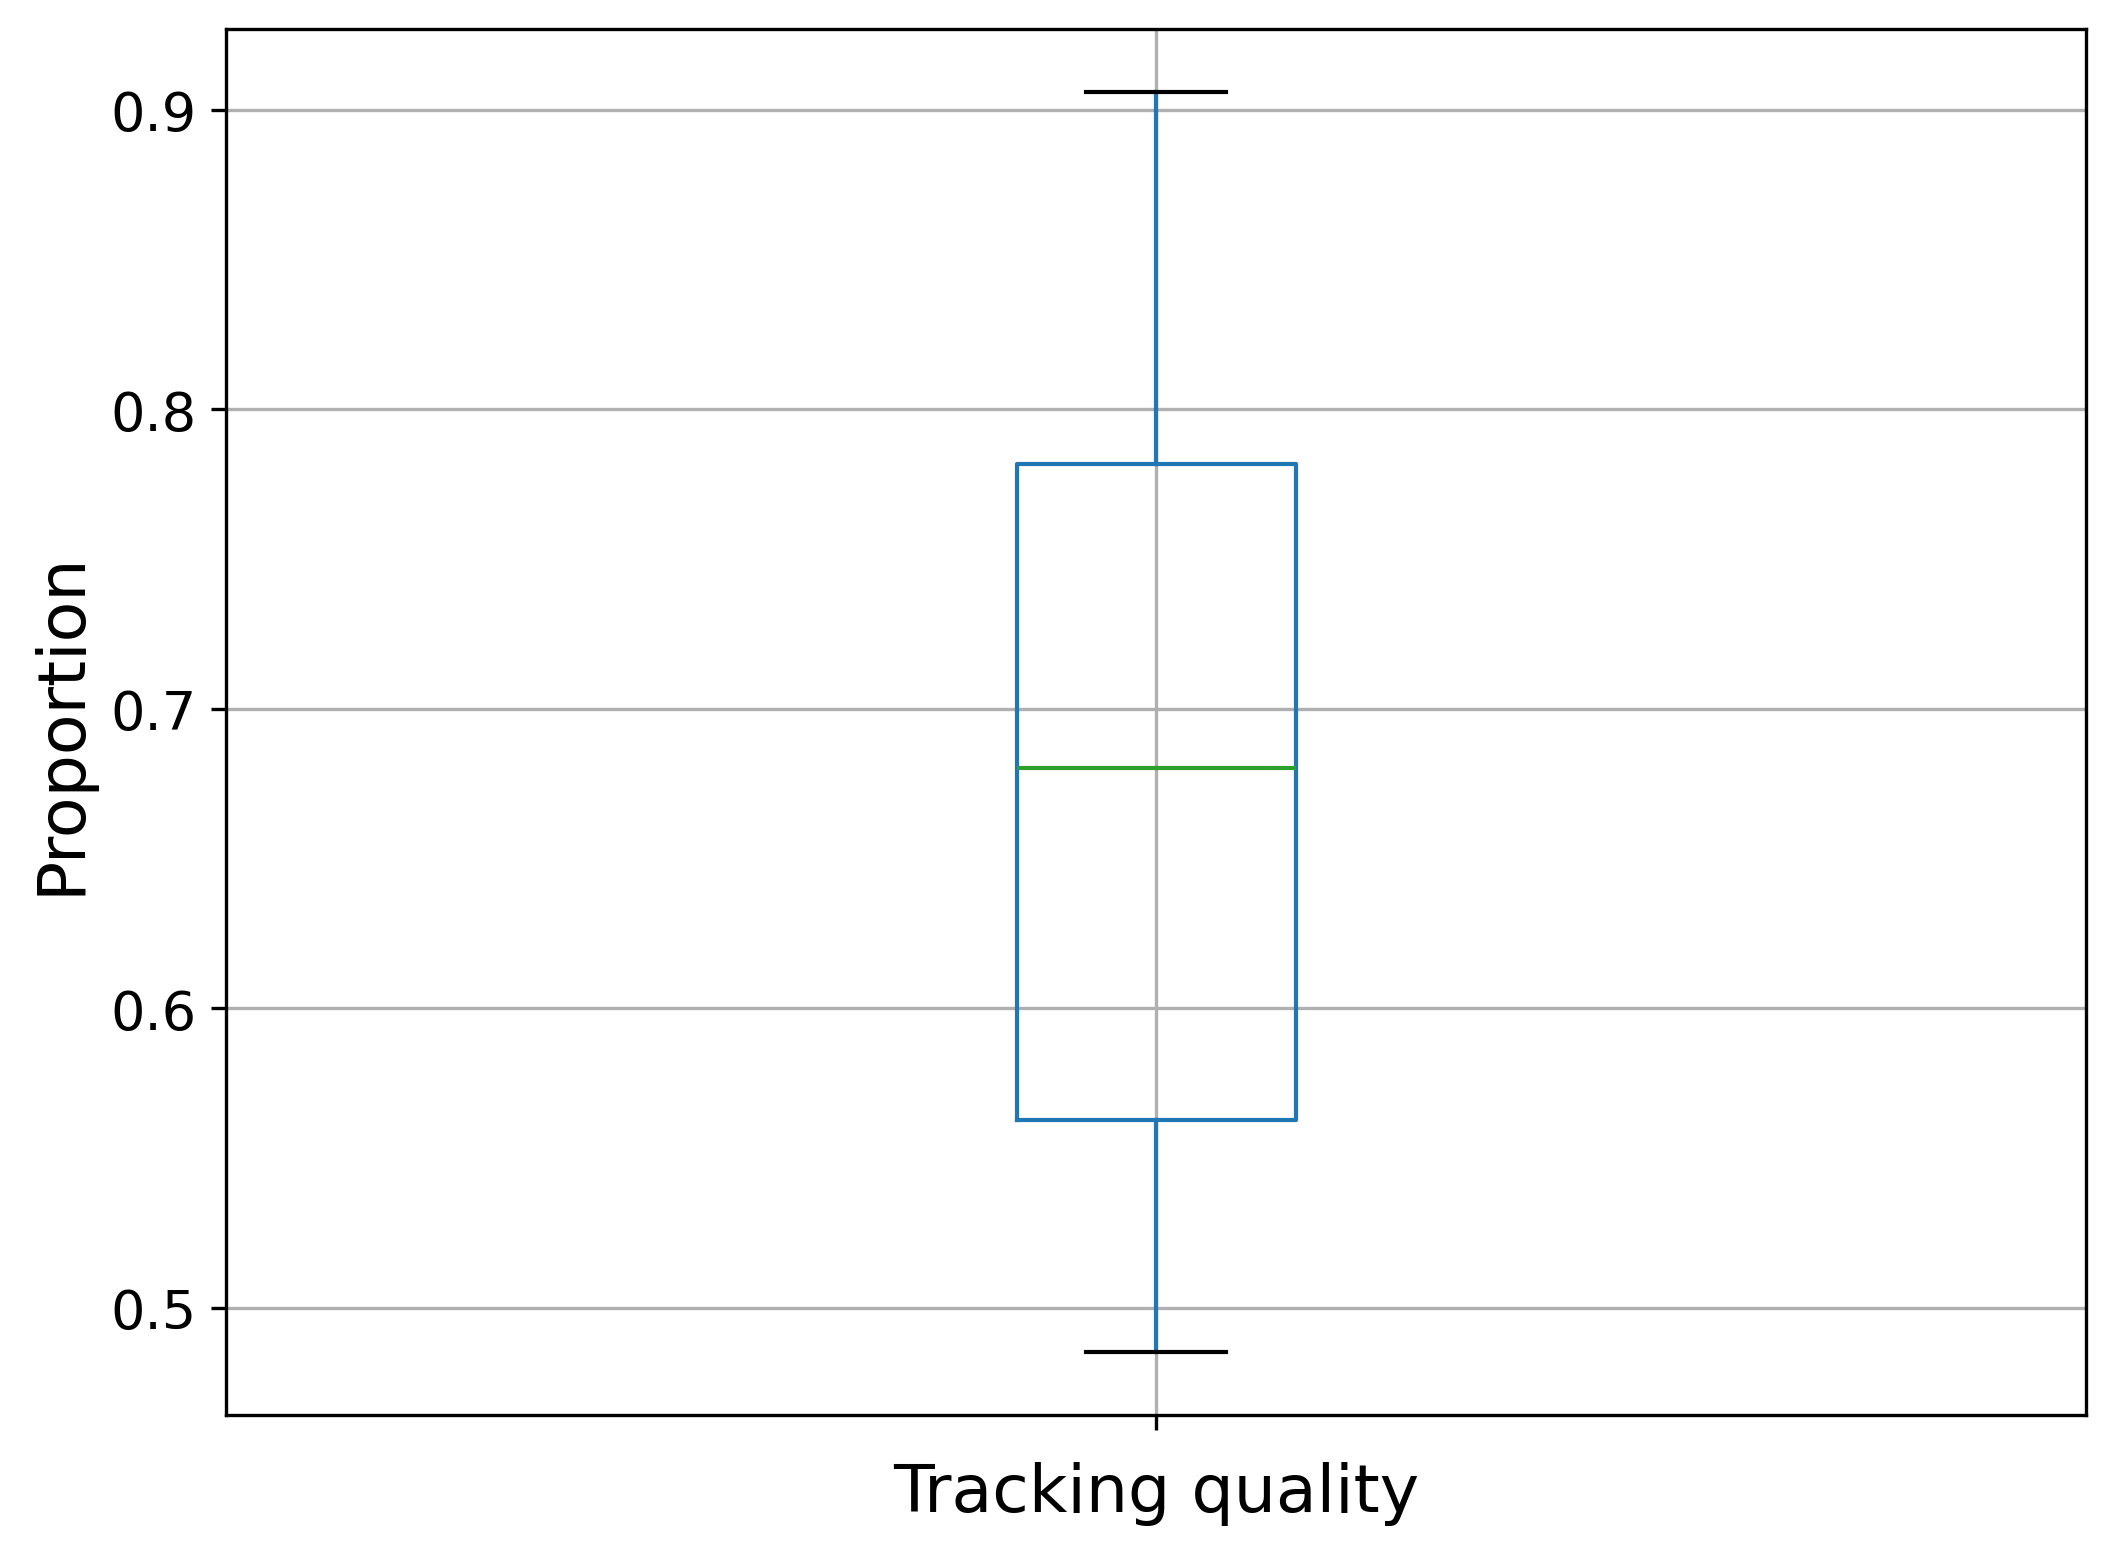

In [22]:
boxplot = total_quality.boxplot(column="quality", figsize=(8, 6))

boxplot.set_xticklabels([])

plt.xlabel("Tracking quality", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
plt.show()